# COVID Deaths Modeling 

In [1]:
# data handling
import pandas as pd
import numpy as np

# seaborn and matplotlib for visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
train = pd.read_csv('../data/training_data.csv', index_col="Unnamed: 0")
train['Date'] = pd.to_datetime(train['Date'])
val = pd.read_csv('../data/validation_data.csv', index_col="Unnamed: 0")
test = pd.read_csv('../data/testing_data.csv', index_col="Unnamed: 0")
death_data = pd.read_csv('../data/death_data_by_age.csv')

In [3]:
train.columns

Index(['Date', 'State', 'Total Pop', 'Day_of_Wk', 'Confirmed',
       'Confirmed_diff', 'Confirmed_rate', 'Confirmed_rate_diff', 'Deaths',
       'Deaths_diff', 'Deaths_rate', 'Deaths_rate_diff', 'Recovered',
       'Recovered_rate', 'Recovered_diff', 'Recovered_rate_diff', 'Active',
       'Active_diff', 'Active_rate_diff', 'Active_rate', 'Case_Fatality_Ratio',
       'Administered', 'Series_Complete_Yes', 'Month', 'Year',
       'Monthly Temp (F)', 'Monthly Avg Temp (F)'],
      dtype='object')

In [4]:
train.head()

,Date,State,Total Pop,Day_of_Wk,Confirmed,Confirmed_diff,Confirmed_rate,Confirmed_rate_diff,Deaths,Deaths_diff,...,Active_diff,Active_rate_diff,Active_rate,Case_Fatality_Ratio,Administered,Series_Complete_Yes,Month,Year,Monthly Temp (F),Monthly Avg Temp (F)
0,2020-04-12,Alabama,4903185,Sunday,3667,NaN,0.000748,NaN,93,NaN,...,NaN,NaN,0.000708,2.610160,0.0,0.0,4,2020,61.55,63.096875
1,2020-04-13,Alabama,4903185,Monday,3870,203.0,0.000789,0.000041,99,6.0,...,165.0,0.000034,0.000741,2.651312,0.0,0.0,4,2020,61.55,63.096875
2,2020-04-14,Alabama,4903185,Tuesday,4041,171.0,0.000824,0.000035,114,15.0,...,204.0,0.000042,0.000783,2.883886,0.0,0.0,4,2020,61.55,63.096875
3,2020-04-15,Alabama,4903185,Wednesday,4307,266.0,0.000878,0.000054,118,4.0,...,118.0,0.000024,0.000807,2.895706,0.0,0.0,4,2020,61.55,63.096875
4,2020-04-16,Alabama,4903185,Thursday,4465,158.0,0.000911,0.000032,133,15.0,...,255.0,0.000052,0.000859,3.060990,0.0,0.0,4,2020,61.55,63.096875


In [6]:
death_data

,Year,Month,State,Age Group,COVID-19 Deaths,Total COVID Deaths,Death Proportion
0,2020,1,Alabama,0-17 years,0.0,0.0,0.0
1,2020,1,Alabama,18-29 years,0.0,0.0,0.0
2,2020,1,Alabama,30-39 years,0.0,0.0,0.0
3,2020,1,Alabama,40-49 years,0.0,0.0,0.0
4,2020,1,Alabama,50-64 years,0.0,0.0,0.0
...,...,...,...,...,...,...,...
5875,2021,3,Wyoming,40-49 years,0.0,0.0,0.0
5876,2021,3,Wyoming,50-64 years,0.0,0.0,0.0
5877,2021,3,Wyoming,65-74 years,0.0,0.0,0.0
5878,2021,3,Wyoming,75-84 years,0.0,0.0,0.0


## Modeling Methods and Metrics

Since our modeling will take and predict data at the _state_ level, we want our metrics to also be computed at the state level. In this case, we want to compute the root mean squared error, so we aggregate our real and predicted values by state, compute the RSME within the state, and then average the RSME accross all states. 

In [7]:
def RSME_df(df, col_names): 
    '''
    df has two columns, one with predictions and one with actual values,
    passed as `col_names` (order irrelevant)
    Returns the RSME of the predictions w.r.t the actual values 
    '''
    return np.sqrt(np.mean((df[col_names[0]] - df[col_names[1]])**2))

def compute_RSME_by_state(model, X, Y):
    '''
    Y must have 'State' in the index 
    '''
    Y_pred = pd.DataFrame(data=model.predict(X), index=Y.index, columns=Y.columns)
    combined_data = Y_pred.merge(Y, left_index=True, right_index=True, suffixes=('_pred','_actual'))    
    
    state_pred = combined_data.groupby('State').agg(RSME_df, col_names = combined_data.columns)
    state_pred.columns = ['RSME',"_"]
    state_pred = state_pred[['RSME']]
    return state_pred

def avg_state_RSME(model, X, Y):
    state_RSMEs = compute_RSME_by_state(model, X, Y)
    return state_RSMEs.mean()

In [8]:
metrics = ['Avg RSME']
datasets = ["Training", "Validation"]


def compute_stats(model, X, Y):
    avg_RSME = avg_state_RSME(model, X, Y)
    # more computed values go here
    return (avg_RSME)

def compute_model_stats(model, X_train, Y_train, X_val, Y_val):
    model_stats = {}
    train_metrics = compute_stats(model, X_train, Y_train)
    model_stats['training'] = dict(zip(metrics, train_metrics))
    val_metrics = compute_stats(model, X_val, Y_val)
    model_stats['validation'] =  dict(zip(metrics, val_metrics))
    return model_stats
    
def print_model_stats(model_stats):
    print("Model Statistics:")
    print('                | ',' | '.join(list(model_stats.keys()), ))
    print('-----------------------------------------')
    for var in model_stats['training'].keys():
        print("{var:<15} |   {train:.3f}   |   {val:.3f}".format(var = var,
                                      train = model_stats['training'][var], 
                                      val   = model_stats['validation'][var]))


In [9]:
iterables = [datasets, metrics]
col_idx = pd.MultiIndex.from_product(iterables, names=["", ""])
    
def make_fresh_record():
    record = pd.DataFrame(columns=col_idx)
    record.index.name = "Model"
    return record 

def record_model_stats(record, model_stats, model_name, override=False): 
    model_stats_df = pd.json_normalize(model_stats, sep='_')
    model_stats_df.columns = col_idx
    model_data = model_stats_df.iloc[0]
    model_data.name = model_name
    new_record = record.copy()
    # override or new entry
    if override or model_name not in record.index:
        new_record.loc[model_name,:] = model_data
    #exists and don't overide 
    else:
        print("Warning: A model with the name '{}' already exists in this record.".format(model_name))
        print("         Either change model_name or set 'override=True'.")
        return record
    return new_record

def make_and_record_model(record, processing_fun, train, val, name, override=False):
    model, (X_train, Y_train), (X_val, Y_val) = processing_fun(train, val)
    model_stats = compute_model_stats(model, X_train, Y_train, X_val, Y_val)
    record = record_model_stats(record, model_stats, name, override)
    return (record, model, model_stats, {"train_data": (X_train, Y_train), "val_data":(X_val, Y_val)})

### COVID Cases Modeling



In [10]:
def relabel_timeseries_data(X, Y, W, col_name="input"):
    timeseries_names = [col_name+'_day_'+str(i) for i in range(1-W,1)]

    target_day = Y.name
    Y.name = 'target_'+col_name
    Y = Y.reset_index()
    X = X.set_axis(timeseries_names, axis=1, inplace=False)
    X['Target_day'] = target_day
    Y['Target_day'] = target_day
    X = X.reset_index()
    X = X.set_index(['Target_day','State'])
    Y = Y.set_index(['Target_day','State'])
    return (X, Y)

def create_timeseries(df, col):
    return df.pivot_table(index = 'State', columns='Date',
                   values=col).sort_values(by = 'Date', axis='columns')


def convert_timeseries_to_data(df, W, col_name='input'):
    '''
    df is a dataframe, with columns sorted in increasing order by date
    splits rows into timeseries data with W columns of 'input' associated 
    with the W+1 column of 'output' and combined for all rows 
    '''
    d = df.shape[1]
    X = df.iloc[:, 0:W]
    Y = df.iloc[:,W]
    X, Y = relabel_timeseries_data(X, Y, W, col_name)

    for i in range(1,d-W):#1,3,..., d-W-1
        X_data = df.iloc[:, i:i+W] # i+W-1 = W+1,W+2,... d-1
        Y_data = df.iloc[:,i+W] # i+W = W+2,W+3,..., W+d-W = d
        X_data, Y_data = relabel_timeseries_data(X_data, Y_data, W, col_name)
        X = X.append(X_data)
        Y = Y.append(Y_data)

    return (X, Y)

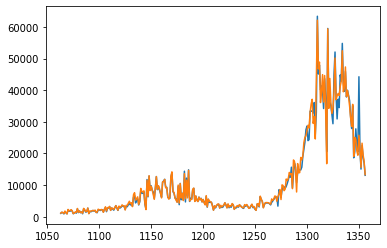

In [38]:
train[train['State']=='California'][['Date','Active']]#.plot()
train[train['State']=='California']['Active_diff'].plot()
train[train['State']=='California']['Confirmed_diff'].plot();

### Model 1 

Feed in confirmed cases for the previous 14 days (since 2 weeks is a standard COVID incubation period) and predict confirmed cases for the next day. 

In [50]:
model_record = make_fresh_record()

In [51]:
from sklearn.linear_model import LinearRegression

def model_1a_pipeline(data, test_data=False): 
    window_size = 14
    active_timeseries_data = create_timeseries(data,'Active_diff')
    X_data, _  = convert_timeseries_to_data(active_timeseries_data, 
                                                window_size, 
                                                col_name="Active_diff")
    death_timeseries_data = create_timeseries(data,'Deaths_diff')
    _, Y_data  = convert_timeseries_to_data(death_timeseries_data, 
                                                window_size, 
                                                col_name="Deaths_diff")
    if test_data:
        return X_data
    else: 
        return (X_data, Y_data)

def model_1a_processing(train, val):
    model = LinearRegression()
    X_train, Y_train = model_1a_pipeline(train)
    X_val, Y_val = model_1a_pipeline(val)
    model.fit(X_train, Y_train)
    return (model, (X_train, Y_train), (X_val, Y_val))

def model_1b_pipeline(data, test_data=False): 
    window_size = 14
    conf_timeseries_data = create_timeseries(data,'Confirmed_diff')
    X_data, _  = convert_timeseries_to_data(conf_timeseries_data, 
                                                window_size, 
                                                col_name="Confirmed_diff")
    death_timeseries_data = create_timeseries(data,'Deaths_diff')
    _, Y_data  = convert_timeseries_to_data(death_timeseries_data, 
                                                window_size, 
                                                col_name="Deaths_diff")
    if test_data:
        return X_data
    else: 
        return (X_data, Y_data)

def model_1b_processing(train, val):
    model = LinearRegression()
    X_train, Y_train = model_1b_pipeline(train)
    X_val, Y_val = model_1b_pipeline(val)
    model.fit(X_train, Y_train)
    return (model, (X_train, Y_train), (X_val, Y_val))

In [52]:
model_record, m1a, m1a_stats, m1a_data = make_and_record_model(model_record, 
                                                  model_1a_processing, train, val, 
                                                  "Active_diff only, 14D")
model_record, m1b, m1b_stats, m1b_data = make_and_record_model(model_record, 
                                                  model_1b_processing, train, val, 
                                                  "Confirmed_diff only, 14D")
model_record

,Training,Validation
,Avg RSME,Avg RSME
Model,,
"Active_diff only, 14D",35.228456,43.576248
"Confirmed_diff only, 14D",27.551477,30.293913


Based on the model above, Confirmed diff seems a more accurate way to predict deaths. 

### Model 2 

In [53]:
death_data.head()

,Year,Month,State,Age Group,COVID-19 Deaths,Total COVID Deaths,Death Proportion
0,2020,1,Alabama,0-17 years,0.0,0.0,0.0
1,2020,1,Alabama,18-29 years,0.0,0.0,0.0
2,2020,1,Alabama,30-39 years,0.0,0.0,0.0
3,2020,1,Alabama,40-49 years,0.0,0.0,0.0
4,2020,1,Alabama,50-64 years,0.0,0.0,0.0


In [54]:
train.head()

,Date,State,Total Pop,Day_of_Wk,Confirmed,Confirmed_diff,Confirmed_rate,Confirmed_rate_diff,Deaths,Deaths_diff,...,Active_diff,Active_rate_diff,Active_rate,Case_Fatality_Ratio,Administered,Series_Complete_Yes,Month,Year,Monthly Temp (F),Monthly Avg Temp (F)
0,2020-04-12,Alabama,4903185,Sunday,3667,NaN,0.000748,NaN,93,NaN,...,NaN,NaN,0.000708,2.610160,0.0,0.0,4,2020,61.55,63.096875
1,2020-04-13,Alabama,4903185,Monday,3870,203.0,0.000789,0.000041,99,6.0,...,165.0,0.000034,0.000741,2.651312,0.0,0.0,4,2020,61.55,63.096875
2,2020-04-14,Alabama,4903185,Tuesday,4041,171.0,0.000824,0.000035,114,15.0,...,204.0,0.000042,0.000783,2.883886,0.0,0.0,4,2020,61.55,63.096875
3,2020-04-15,Alabama,4903185,Wednesday,4307,266.0,0.000878,0.000054,118,4.0,...,118.0,0.000024,0.000807,2.895706,0.0,0.0,4,2020,61.55,63.096875
4,2020-04-16,Alabama,4903185,Thursday,4465,158.0,0.000911,0.000032,133,15.0,...,255.0,0.000052,0.000859,3.060990,0.0,0.0,4,2020,61.55,63.096875


In [61]:
death_with_idx = death_data.set_index(['Year','Month','State'])

death_train = train.merge(death_with_idx, how="left", left_on=['Year','Month','State'],right_index=True)
death_val   = val.merge(death_with_idx, how="left", left_on=['Year','Month','State'],right_index=True)
death_test  = test.merge(death_with_idx, how="left", left_on=['Year','Month','State'],right_index=True)
death_test

,Date,State,Total Pop,Day_of_Wk,Confirmed,Confirmed_diff,Confirmed_rate,Confirmed_rate_diff,Deaths,Deaths_diff,...,Administered,Series_Complete_Yes,Month,Year,Monthly Temp (F),Monthly Avg Temp (F),Age Group,COVID-19 Deaths,Total COVID Deaths,Death Proportion
323,2021-03-01,Alabama,4903185,Monday,493769,517.0,0.100704,0.000105,9931,2.0,...,948393.0,0.0,3,2021,59.075,55.85875,0-17 years,0.0,167.0,0.000000
323,2021-03-01,Alabama,4903185,Monday,493769,517.0,0.100704,0.000105,9931,2.0,...,948393.0,0.0,3,2021,59.075,55.85875,18-29 years,0.0,167.0,0.000000
323,2021-03-01,Alabama,4903185,Monday,493769,517.0,0.100704,0.000105,9931,2.0,...,948393.0,0.0,3,2021,59.075,55.85875,30-39 years,0.0,167.0,0.000000
323,2021-03-01,Alabama,4903185,Monday,493769,517.0,0.100704,0.000105,9931,2.0,...,948393.0,0.0,3,2021,59.075,55.85875,40-49 years,0.0,167.0,0.000000
323,2021-03-01,Alabama,4903185,Monday,493769,517.0,0.100704,0.000105,9931,2.0,...,948393.0,0.0,3,2021,59.075,55.85875,50-64 years,28.0,167.0,0.167665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17345,2021-03-31,Wyoming,578759,Wednesday,56310,74.0,0.097294,0.000128,700,5.0,...,262406.0,105052.0,3,2021,32.030,32.58550,40-49 years,0.0,0.0,0.000000
17345,2021-03-31,Wyoming,578759,Wednesday,56310,74.0,0.097294,0.000128,700,5.0,...,262406.0,105052.0,3,2021,32.030,32.58550,50-64 years,0.0,0.0,0.000000
17345,2021-03-31,Wyoming,578759,Wednesday,56310,74.0,0.097294,0.000128,700,5.0,...,262406.0,105052.0,3,2021,32.030,32.58550,65-74 years,0.0,0.0,0.000000
17345,2021-03-31,Wyoming,578759,Wednesday,56310,74.0,0.097294,0.000128,700,5.0,...,262406.0,105052.0,3,2021,32.030,32.58550,75-84 years,0.0,0.0,0.000000


In [74]:
death_train[['State','Date','Age Group','Death Proportion']].pivot(index= ['Date','State'],columns='Age Group',values='Death Proportion')

Age Group                 0-17 years  18-29 years  30-39 years  40-49 years  \
Date       State                                                              
2020-04-12 Alabama               0.0          0.0     0.000000     0.000000   
           Arizona               0.0          0.0     0.000000     0.030380   
           Arkansas              0.0          0.0     0.000000     0.000000   
           California            0.0          0.0     0.018426     0.040339   
           Colorado              0.0          0.0     0.000000     0.024166   
...                              ...          ...          ...          ...   
2021-01-31 Virginia              0.0          0.0     0.004863     0.012378   
           Washington            0.0          0.0     0.000000     0.018717   
           West Virginia         0.0          0.0     0.000000     0.016058   
           Wisconsin             0.0          0.0     0.000000     0.014620   
           Wyoming               0.0          0.0     0.000000     0.000000   

Age Group                 50-64 years  65-74 years  75-84 years  \
Date       State                                                  
2020-04-12 Alabama           0.215805     0.264438     0.279635   
           Arizona           0.136709     0.192405     0.288608   
           Arkansas          0.224490     0.000000     0.346939   
           California        0.155378     0.188745     0.264940   
           Colorado          0.102417     0.209436     0.269275   
...                               ...          ...          ...   
2021-01-31 Virginia          0.118479     0.217949     0.288240   
           Washington        0.096257     0.223262     0.308824   
           West Virginia     0.118248     0.251095     0.337226   
           Wisconsin         0.097466     0.187135     0.306043   
           Wyoming           0.112245     0.234694     0.316327   

Age Group                 85 years and over  
Date       State                             
2020-04-12 Alabama                 0.240122  
           Arizona                 0.351899  
           Arkansas                0.428571  
           California              0.332171  
           Colorado                0.394707  
...                                     ...  
2021-01-31 Virginia                0.358090  
           Washington              0.352941  
           West Virginia           0.277372  
           Wisconsin               0.394737  
           Wyoming                 0.336735  

[14455 rows x 8 columns]

In [75]:
def model_2_pipeline(data, test_data=False): 
    window_size = 14
    
    X_age_data = (data[['State','Date','Age Group','Death Proportion']]
                  .pivot(index= ['Date','State'],
                         columns='Age Group',
                         values='Death Proportion'))
    X_age_data.index = X_age_data.index.set_names('Target_day', level=0)
    
    cases_timeseries_data = create_timeseries(data,'Confirmed_diff')
    X_case_data, _  = convert_timeseries_to_data(cases_timeseries_data, 
                                                window_size, 
                                                col_name="Confirmed_diff")
    
    death_timeseries_data = create_timeseries(data,'Deaths_diff')
    _, Y_data  = convert_timeseries_to_data(death_timeseries_data, 
                                                window_size, 
                                                col_name="Deaths_diff")
    
    X_data = X_case_data.merge(X_age_data, how="left", left_index=True, right_index=True)

    if test_data:
        return X_data
    else: 
        return (X_data, Y_data)

def model_2_processing(train, val):
    model = LinearRegression()
    X_train, Y_train = model_2_pipeline(train)
    X_val, Y_val = model_2_pipeline(val)
    model.fit(X_train, Y_train)
    return (model, (X_train, Y_train), (X_val, Y_val))

In [79]:
model_record, m2, m2_stats, m2_data = make_and_record_model(model_record, 
                                                  model_2_processing, death_train, death_val, 
                                                  "Confirmed_diff, age death props, 14D")
model_record

,Training,Validation
,Avg RSME,Avg RSME
Model,,
"Active_diff only, 14D",35.228456,43.576248
"Confirmed_diff only, 14D",27.551477,30.293913
"Confirmed_diff, age death props, 14D",27.068359,29.720147


,Date,State,Total Pop,Day_of_Wk,Confirmed,Confirmed_diff,Confirmed_rate,Confirmed_rate_diff,Deaths,Deaths_diff,...,Administered,Series_Complete_Yes,Month,Year,Monthly Temp (F),Monthly Avg Temp (F),Age Group,COVID-19 Deaths,Total COVID Deaths,Death Proportion
0,2020-04-12,Alabama,4903185,Sunday,3667,NaN,0.000748,NaN,93,NaN,...,0.0,0.0,4,2020,61.55,63.096875,0-17 years,0.0,329.0,0.000000
0,2020-04-12,Alabama,4903185,Sunday,3667,NaN,0.000748,NaN,93,NaN,...,0.0,0.0,4,2020,61.55,63.096875,18-29 years,0.0,329.0,0.000000
0,2020-04-12,Alabama,4903185,Sunday,3667,NaN,0.000748,NaN,93,NaN,...,0.0,0.0,4,2020,61.55,63.096875,30-39 years,0.0,329.0,0.000000
0,2020-04-12,Alabama,4903185,Sunday,3667,NaN,0.000748,NaN,93,NaN,...,0.0,0.0,4,2020,61.55,63.096875,40-49 years,0.0,329.0,0.000000
0,2020-04-12,Alabama,4903185,Sunday,3667,NaN,0.000748,NaN,93,NaN,...,0.0,0.0,4,2020,61.55,63.096875,50-64 years,71.0,329.0,0.215805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17286,2021-01-31,Wyoming,578759,Sunday,51912,208.0,0.089695,0.000359,596,0.0,...,57023.0,0.0,1,2021,23.39,22.051000,40-49 years,0.0,98.0,0.000000
17286,2021-01-31,Wyoming,578759,Sunday,51912,208.0,0.089695,0.000359,596,0.0,...,57023.0,0.0,1,2021,23.39,22.051000,50-64 years,11.0,98.0,0.112245
17286,2021-01-31,Wyoming,578759,Sunday,51912,208.0,0.089695,0.000359,596,0.0,...,57023.0,0.0,1,2021,23.39,22.051000,65-74 years,23.0,98.0,0.234694
17286,2021-01-31,Wyoming,578759,Sunday,51912,208.0,0.089695,0.000359,596,0.0,...,57023.0,0.0,1,2021,23.39,22.051000,75-84 years,31.0,98.0,0.316327


In [106]:
copy_df = (death_train[['State','Date','Age Group','Death Proportion']]
                  .pivot(index= ['Date','State'],
                         columns='Age Group',
                         values='Death Proportion').copy())
copy_df['0-29']  = copy_df['0-17 years'] + copy_df['18-29 years'] 
copy_df['30-64'] = copy_df['30-39 years'] + copy_df['40-49 years'] + copy_df['50-64 years'] 
copy_df['65+']  = copy_df['65-74 years'] + copy_df['75-84 years'] + copy_df['85 years and over'] 
copy_df

Age Group                 0-17 years  18-29 years  30-39 years  40-49 years  \
Date       State                                                              
2020-04-12 Alabama               0.0          0.0     0.000000     0.000000   
           Arizona               0.0          0.0     0.000000     0.030380   
           Arkansas              0.0          0.0     0.000000     0.000000   
           California            0.0          0.0     0.018426     0.040339   
           Colorado              0.0          0.0     0.000000     0.024166   
...                              ...          ...          ...          ...   
2021-01-31 Virginia              0.0          0.0     0.004863     0.012378   
           Washington            0.0          0.0     0.000000     0.018717   
           West Virginia         0.0          0.0     0.000000     0.016058   
           Wisconsin             0.0          0.0     0.000000     0.014620   
           Wyoming               0.0          0.0     0.000000     0.000000   

Age Group                 50-64 years  65-74 years  75-84 years  \
Date       State                                                  
2020-04-12 Alabama           0.215805     0.264438     0.279635   
           Arizona           0.136709     0.192405     0.288608   
           Arkansas          0.224490     0.000000     0.346939   
           California        0.155378     0.188745     0.264940   
           Colorado          0.102417     0.209436     0.269275   
...                               ...          ...          ...   
2021-01-31 Virginia          0.118479     0.217949     0.288240   
           Washington        0.096257     0.223262     0.308824   
           West Virginia     0.118248     0.251095     0.337226   
           Wisconsin         0.097466     0.187135     0.306043   
           Wyoming           0.112245     0.234694     0.316327   

Age Group                 85 years and over  0-29     30-64       65+  
Date       State                                                       
2020-04-12 Alabama                 0.240122   0.0  0.215805  0.784195  
           Arizona                 0.351899   0.0  0.167089  0.832911  
           Arkansas                0.428571   0.0  0.224490  0.775510  
           California              0.332171   0.0  0.214143  0.785857  
           Colorado                0.394707   0.0  0.126582  0.873418  
...                                     ...   ...       ...       ...  
2021-01-31 Virginia                0.358090   0.0  0.135721  0.864279  
           Washington              0.352941   0.0  0.114973  0.885027  
           West Virginia           0.277372   0.0  0.134307  0.865693  
           Wisconsin               0.394737   0.0  0.112086  0.887914  
           Wyoming                 0.336735   0.0  0.112245  0.887755  

[14455 rows x 11 columns]

In [120]:
def model_3_pipeline(data, test_data=False): 
    window_size = 14
    
    X_age_data = (data[['State','Date','Age Group','Death Proportion']]
                  .pivot(index= ['Date','State'],
                         columns='Age Group',
                         values='Death Proportion'))
    X_age_data.index = X_age_data.index.set_names('Target_day', level=0)
    X_age_data['0-29']  = X_age_data['0-17 years'] + X_age_data['18-29 years'] 
    X_age_data['30-64'] = X_age_data['30-39 years'] + X_age_data['40-49 years'] + X_age_data['50-64 years'] 
    X_age_data['65+']   = X_age_data['65-74 years'] + X_age_data['75-84 years'] + X_age_data['85 years and over'] 
    
    cases_timeseries_data = create_timeseries(data,'Confirmed_diff')
    X_case_data, _  = convert_timeseries_to_data(cases_timeseries_data, 
                                                window_size, 
                                                col_name="Confirmed_diff")
    
    death_timeseries_data = create_timeseries(data,'Deaths_diff')
    _, Y_data  = convert_timeseries_to_data(death_timeseries_data, 
                                                window_size, 
                                                col_name="Deaths_diff")
    X_case_data_scaled = X_case_data.mul(X_age_data['30-64'],axis=0)
    X_data = X_case_data.merge(X_case_data_scaled, how="left", left_index=True, right_index=True)

    if test_data:
        return X_data
    else: 
        return (X_data, Y_data)

def model_3_processing(train, val):
    model = LinearRegression()
    X_train, Y_train = model_3_pipeline(train)
    X_val, Y_val = model_3_pipeline(val)
    model.fit(X_train, Y_train)
    return (model, (X_train, Y_train), (X_val, Y_val))

In [121]:
model_record, m3, m3_stats, m3_data = make_and_record_model(model_record, 
                                                  model_3_processing, death_train, death_val, 
                                                  "Confirmed_diff, cases scaled by 65+, 14D", override=True)
model_record

,Training,Validation
,Avg RSME,Avg RSME
Model,,
"Active_diff only, 14D",35.228456,43.576248
"Confirmed_diff only, 14D",27.551477,30.293913
"Confirmed_diff, age death props, 14D",27.068359,29.720147
"Confirmed_diff, cases scaled by 65+, 14D",27.420183,29.951528
